In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds={'alpha':0.5,'s':80,'linewidth':0}


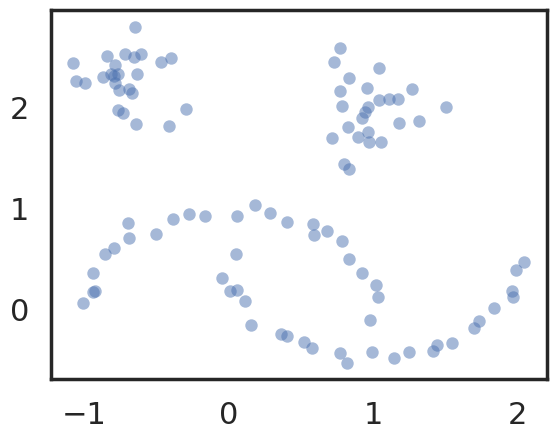

In [2]:
moons,_ = data.make_moons(n_samples=50,noise=0.05)
blobs,_ = data.make_blobs(n_samples=50,centers=[(-0.75,2.25),(1.0,2.0)],cluster_std=0.25)
test_data=np.vstack([moons,blobs])
plt.scatter(test_data.T[0],test_data.T[1],color='b',**plot_kwds)

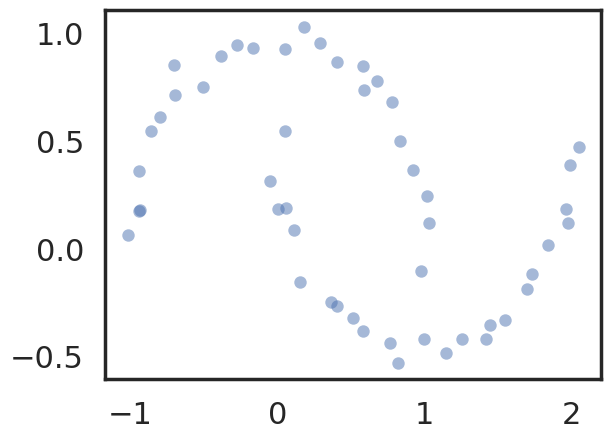

In [3]:
plt.scatter(moons.T[0],moons.T[1],color='b',**plot_kwds)

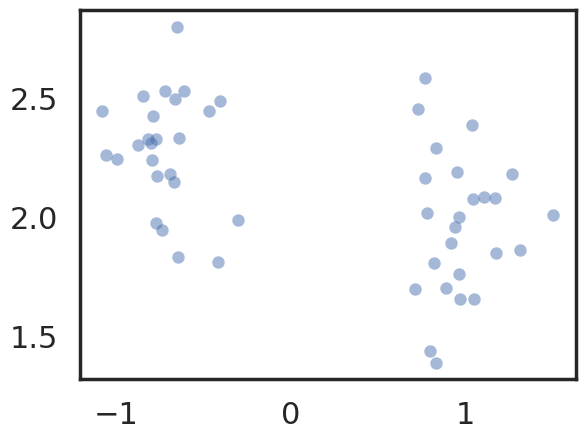

In [4]:
plt.scatter(blobs.T[0],blobs.T[1],color='b',**plot_kwds)

In [7]:
!pip install hdbscan
import hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039287 sha256=9a59a785e86fa128ebf0801c4138beee7b6ba2c1345b640f2fd6865ce5858024
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


In [8]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5,gen_min_span_tree=True)
clusterer.fit(test_data)

HDBSCAN(gen_min_span_tree=True)

1. Transform the space according to the density/sparsity.
2. Build the minimum spanning tree of the distance weighted graph.
3. Construct a cluster hierarchy of connected componnents.
4. Condense the cluster hierarchy based on minimum cluster size.
5. Extract the stable clusters from the condensed tree.

**Transform the space**
 mutual reachability distance. We define mutual reachability distance as follows:

d(mreach-k)(a,b)=
max{core(k)(a),core(k)(b),d(a,b)}


**Build the minimum spanning tree**

<Axes: >

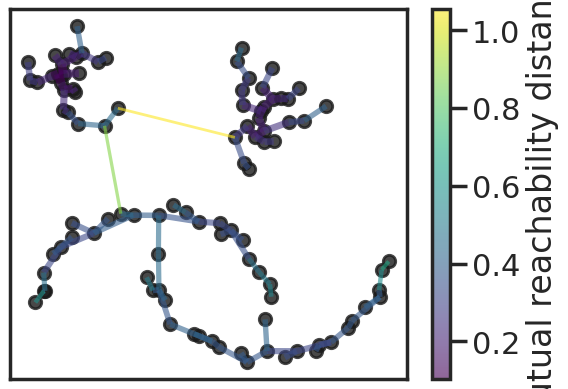

In [9]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',edge_alpha=0.6,node_size=80,edge_linewidth=2)

**Build the cluster hierarcy**

<Axes: ylabel='distance'>

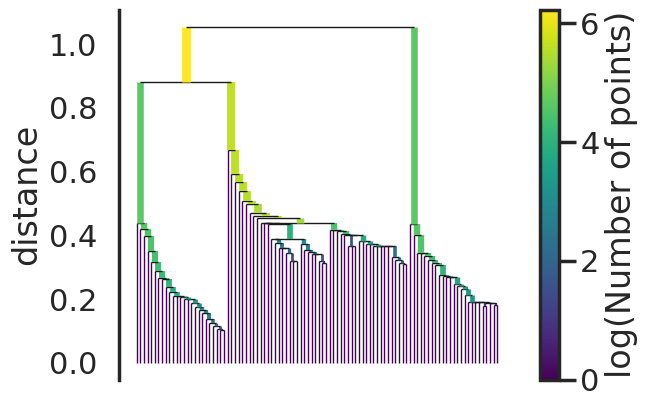

In [10]:
clusterer.single_linkage_tree_.plot(cmap="viridis",colorbar=True)

**Condense the cluster tree**
Once we have a value for minimum cluster size we can now walk through the hierarchy and at each split ask if one of the new clusters created by the split has fewer points than the minimum cluster size. If it is the case that we have fewer points than the minimum cluster size we declare it to be ‘points falling out of a cluster’ and have the larger cluster retain the cluster identity of the parent, marking down which points ‘fell out of the cluster’ and at what distance value that happened.
If on the other hand the split is into two clusters each at least as large as the minimum cluster size then we consider that a true cluster split and let that split persist in the tree. After walking through the whole hierarchy and doing this we end up with a much smaller tree with a small number of nodes, each of which has data about how the size of the cluster at that node decreases over varying distance. We can visualize this as a dendrogram similar to the one above – again we can have the width of the line represent the number of points in the cluster.



<Axes: ylabel='$\\lambda$ value'>

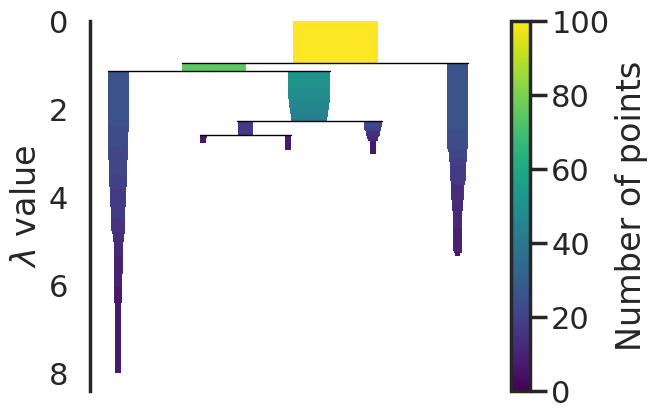

In [11]:
clusterer.condensed_tree_.plot()

**Extract the clusters**
sum (p belonging to cluster){lambda(p)-lambda(birth)}
Intuitively we want the choose clusters that persist and have a longer lifetime; short lived clusters are probably merely artifacts of the single linkage approach. Looking at the previous plot we could say that we want to choose those clusters that have the greatest area of ink in the plot. To make a flat clustering we will need to add a further requirement that, if you select a cluster, then you cannot select any cluster that is a descendant of it. And in fact that intuitive notion of what should be done is exactly what HDBSCAN does. Of course we need to formalise things to make it a concrete algorithm.

First we need a different measure than distance to consider the persistence of clusters; instead we will use \lambda = \frac{1}{\mathrm{distance}}. For a given cluster we can then define values \lambda_{\mathrm{birth}} and \lambda_{\mathrm{death}} to be the lambda value when the cluster split off and became it’s own cluster, and the lambda value (if any) when the cluster split into smaller clusters respectively. In turn, for a given cluster, for each point p in that cluster we can define the value \lambda_p as the lambda value at which that point ‘fell out of the cluster’ which is a value somewhere between \lambda_{\mathrm{birth}} and \lambda_{\mathrm{death}} since the point either falls out of the cluster at some point in the cluster’s lifetime, or leaves the cluster when the cluster splits into two smaller clusters. Now, for each cluster compute the stability as

\sum_{p \in \mathrm{cluster}} (\lambda_p - \lambda_{\mathrm{birth}}).

Declare all leaf nodes to be selected clusters. Now work up through the tree (the reverse topological sort order). If the sum of the stabilities of the child clusters is greater than the stability of the cluster, then we set the cluster stability to be the sum of the child stabilities. If, on the other hand, the cluster’s stability is greater than the sum of its children then we declare the cluster to be a selected cluster and unselect all its descendants. Once we reach the root node we call the current set of selected clusters our flat clustering and return that.

Okay, that was wordy and complicated, but it really is simply performing our ‘select the clusters in the plot with the largest total ink area’ subject to descendant constraints that we explained earlier. We can select the clusters in the condensed tree dendrogram via this algorithm, and you get what you expect:

<Axes: ylabel='$\\lambda$ value'>

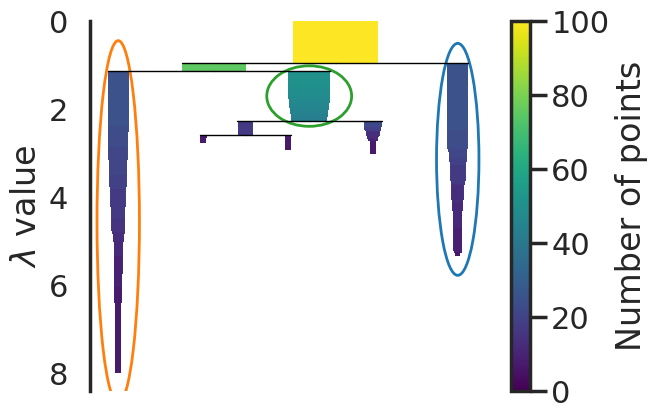

In [13]:
clusterer.condensed_tree_.plot(select_clusters=True,selection_palette=sns.color_palette())

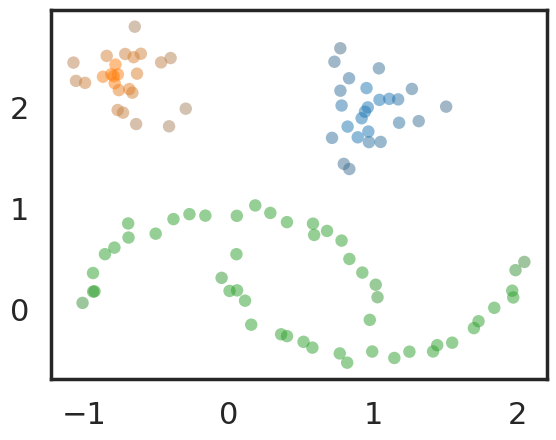

In [15]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col],sat) if col>=0 else(0.5,0.5,0.5) for col, sat in zip(clusterer.labels_,clusterer.probabilities_)]
plt.scatter(test_data.T[0],test_data.T[1],c=cluster_colors,**plot_kwds)